# Identifying Gray Matter Markers of Irritability: a machine learning approach
This notebook is designed to analyze previously processed gray matter density volumes using support vector regression.

In [1]:
from nipype.pipeline.engine import Workflow, Node, MapNode
from nipype.interfaces.utility import IdentityInterface, Function
from nipype.interfaces.io import SelectFiles, DataSink, DataGrabber
from nipype.algorithms.misc import Gunzip
from nipype.interfaces.spm.preprocess import VBMSegment, Segment
from nipype.interfaces.ants import Atropos, Registration, ApplyTransforms, N4BiasFieldCorrection
from nipype.interfaces.fsl import ApplyMask, BET
from pandas import DataFrame, Series, read_csv

# Study specific variables
study_home = '/moochie/Cat/Aggregate_anats/GMD_ML'

sub_data_file = study_home + '/doc/subject_info.csv'
subject_info = read_csv(sub_data_file, index_col=0)
subjects_list = subject_info['freesurferID'].tolist()

preproc_dir = study_home + '/proc'
output_dir = study_home + '/ml_trainingset'

sample_template = study_home + '/templates/lcbd_template_1mm.nii.gz'
sample_template_brain = study_home + '/templates/lcbd_template_1mm_brain.nii.gz'
sample_template_mask = study_home + '/templates/lcbd_template_1mm_mask.nii.gz'

subject_info.describe()

,X,SubjectID,Sequence.Version,Potentially.Usable,in_analysis,Age_yrs,Age_mos,male,MAP_Temper_Loss,MAP_Noncompliance,MAP_General_Aggression,MAP_Low_Concern,CT_QC,DB_factor,anger_factor
count,124.000000,124.000000,124.000000,124.0,124.0,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.0,1.240000e+02,1.240000e+02
mean,62.500000,866.846774,2.322581,1.0,1.0,7.934468,94.669355,0.548387,18.435484,3.879812,3.030645,3.212366,1.0,-3.491830e-17,7.162729e-17
std,35.939764,779.790915,1.172506,0.0,0.0,1.858575,22.297953,0.499672,18.667933,3.907137,3.364519,3.462073,0.0,9.892877e-01,9.751110e-01
min,1.000000,2.000000,1.000000,1.0,1.0,4.169747,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,-9.809568e-01,-9.430157e-01
25%,31.750000,124.500000,1.000000,1.0,1.0,6.602327,78.750000,0.000000,5.000000,1.000000,0.480000,0.444444,1.0,-7.288749e-01,-7.292083e-01
50%,62.500000,1003.000000,2.000000,1.0,1.0,7.801506,93.000000,1.000000,11.500000,2.285714,1.960000,2.222222,1.0,-3.977944e-01,-3.399123e-01
75%,93.250000,2000.750000,3.000000,1.0,1.0,9.061602,108.000000,1.000000,28.000000,5.178636,4.000000,5.000000,1.0,3.597423e-01,4.366664e-01
max,124.000000,2038.000000,4.000000,1.0,1.0,12.465435,149.000000,1.000000,81.000000,15.429091,13.600000,15.111111,1.0,3.287895e+00,3.242505e+00


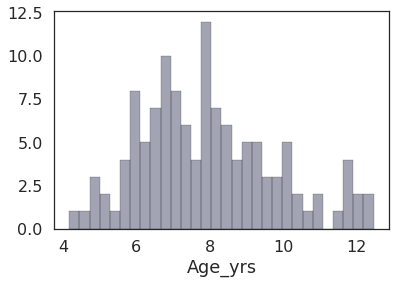

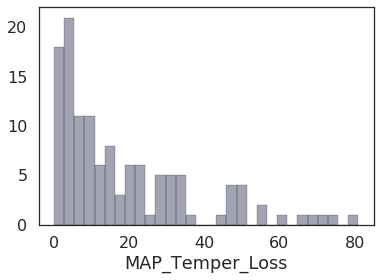

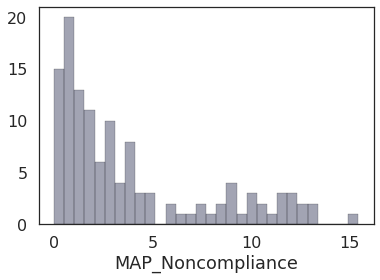

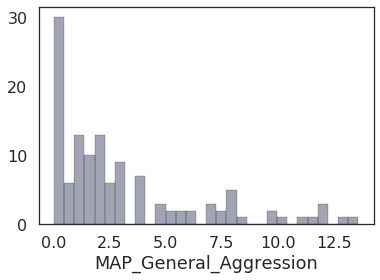

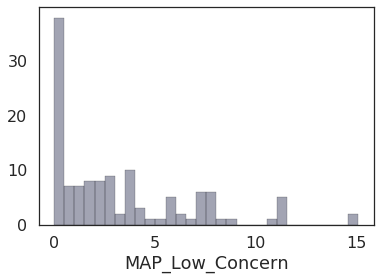

<Figure size 432x288 with 0 Axes>

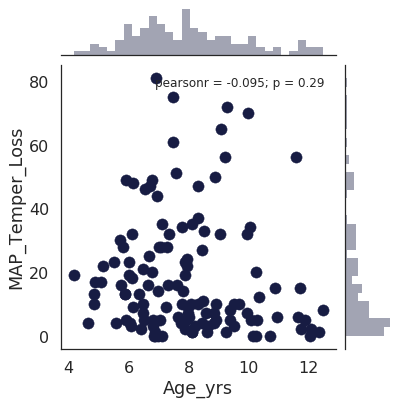

<Figure size 432x288 with 0 Axes>

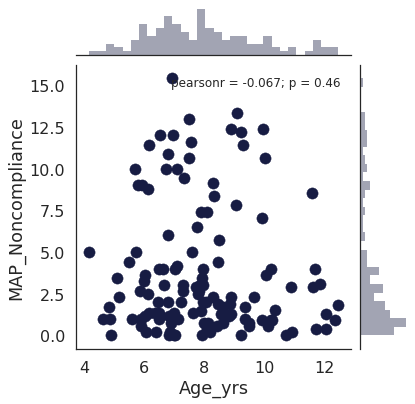

<Figure size 432x288 with 0 Axes>

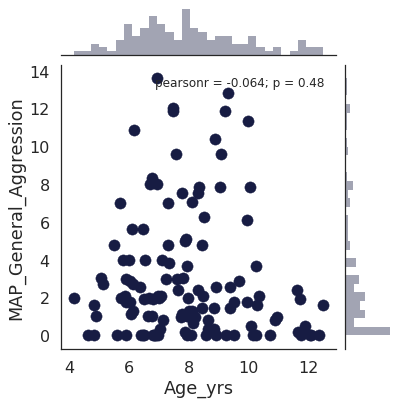

<Figure size 432x288 with 0 Axes>

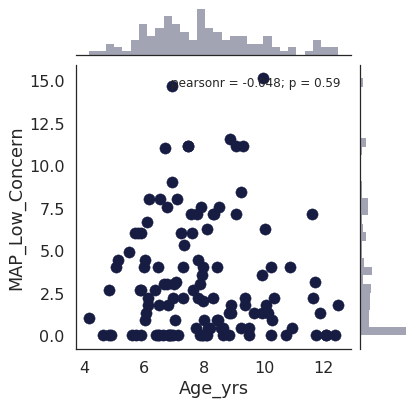

In [3]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
from scipy import stats
warnings.filterwarnings('ignore')
sns.set(context='poster',style='white')
for variable in ['Age_yrs', 'MAP_Temper_Loss','MAP_Noncompliance','MAP_General_Aggression','MAP_Low_Concern']:
    plt.figure()
    sns.distplot(subject_info[variable],hist=True,kde=False,bins=30, color='#171C43', hist_kws={'edgecolor':'black'})
    #plt.savefig(variable+'_hist.svg')
    
for variable in ['MAP_Temper_Loss','MAP_Noncompliance','MAP_General_Aggression','MAP_Low_Concern']:
    plt.figure()
    a = sns.jointplot(subject_info['Age_yrs'],subject_info[variable],color='#171C43',
                      marginal_kws={'kde':False,'bins':30})
    a.annotate(stats.pearsonr,fontsize=12)
    #plt.savefig(variable+'_age_corr.svg')
    plt.show()


In [2]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
from numpy import squeeze

## Create a conditions list for the feature set
age_labels = subject_info[['Age_yrs']].copy()
age_labels = age_labels.values
irr_labels = subject_info[['MAP_Temper_Loss','MAP_Noncompliance','MAP_General_Aggression','MAP_Low_Concern']].copy()
irr_labels = irr_labels.values

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(age_labels)
sd_agedata = scaler.transform(age_labels)

pt = PowerTransformer()
pt.fit(irr_labels)
pt_irritability = pt.transform(irr_labels)
pt_irritability = squeeze(pt_irritability)

conditions = DataFrame(data=sd_agedata, index=None, columns=['age'])
conditions['subject'] = Series(subjects_list, index=conditions.index)
conditions = conditions.merge(DataFrame(pt_irritability,
                                        columns=['Temper_Loss','Noncompliance','General_Aggression','Low_Concern'],
                                        index=conditions.index),left_index=True, right_index=True)
conditions['sequence'] = subject_info['Sequence.Version']
conditions['dbfactor'] = subject_info['DB_factor']
conditions['angfactor'] = subject_info['anger_factor']
conditions['age_yrs'] = subject_info['Age_yrs']
#conditions.to_csv(output_dir + '/featureset_key.csv')
conditions.describe()

,age,Temper_Loss,Noncompliance,General_Aggression,Low_Concern,sequence,dbfactor,angfactor,age_yrs
count,1.240000e+02,1.240000e+02,1.240000e+02,1.240000e+02,1.240000e+02,123.000000,123.000000,123.000000,123.000000
mean,-8.953411e-19,8.058070e-18,1.477313e-17,-1.181850e-16,-6.088320e-17,2.308943,0.005302,0.005492,7.946423
std,1.004057e+00,1.004057e+00,1.004057e+00,1.004057e+00,1.004057e+00,1.167385,0.991564,0.977172,1.861383
min,-2.033813e+00,-1.897661e+00,-1.668984e+00,-1.360780e+00,-1.320305e+00,1.000000,-0.980957,-0.943016,4.169747
25%,-7.196618e-01,-6.568501e-01,-7.701911e-01,-8.665230e-01,-8.804001e-01,1.000000,-0.730615,-0.732143,6.644764
50%,-7.183020e-02,-2.569714e-02,-1.264691e-01,7.229871e-03,7.943811e-02,2.000000,-0.385782,-0.339810,7.816564
75%,6.089106e-01,8.064686e-01,6.908372e-01,6.682785e-01,8.225560e-01,3.000000,0.370725,0.441102,9.069131
max,2.447761e+00,2.017740e+00,1.960505e+00,2.019251e+00,2.004791e+00,4.000000,3.287895,3.242505,12.465435


In [3]:
## Concatenate all the parameter estimates from preproc to create a feature set
from glob import glob
from nipype.interfaces.fsl.utils import Merge
from nipype.interfaces.fsl import SUSAN, Threshold
files = glob(preproc_dir + '/soft_tissue_files/*/POSTERIOR_02.nii.gz')
files = sorted(files)

def brightthresh(img):
    import nibabel as nib
    from numpy import median, where
    
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    
    img_nifti1 = nib.load(img)
    img_data = img_nifti1.get_data()
    img_data = img_data.astype(float)
    
    brain_values = where(img_data > 0)
    median_thresh = median(brain_values)
    bright_thresh = 0.75 * median_thresh
    
    return(bright_thresh)

sm = SUSAN()
sm.inputs.fwhm=4
thr = Threshold()
thr.inputs.thresh=0.05
thr.inputs.direction='below'

for file in files:
    #sm.inputs.brightness_threshold = brightthresh(file)
    sm.inputs.in_file = file
    sm.inputs.out_file = file.replace('POSTERIOR_02','smoothed_gm')
    #sm.run()
    thr.inputs.in_file = sm.inputs.out_file
    thr.inputs.out_file = file.replace('POSTERIOR_02','final_smooth_gm')
    #thr.run()
    

gm_files = glob(preproc_dir + '/soft_tissue_files/*/final_smooth_gm.nii.gz')
gm_files = sorted(gm_files)
gmd_feature_data = output_dir + '/gmd_combined.nii.gz'

merge = Merge()
merge.inputs.in_files = gm_files
merge.inputs.dimension = 't'
merge.inputs.merged_file = gmd_feature_data
#merge.run()

In [4]:
from nilearn.input_data import NiftiMasker

analysis = 'Temper_Loss_LOSO'
masker = NiftiMasker(mask_img=sample_template_mask,standardize=True, 
                     memory='nilearn_cache', memory_level=1)
X = masker.fit_transform(gmd_feature_data)

if analysis == 'Age_LOSO':
    labels = conditions['age']
    groups = conditions['subject']
elif analysis == 'Temper_Loss_LOSO':
    labels = conditions['Temper_Loss']
    groups = conditions['subject']
elif analysis == 'Noncompliance_LOSO':
    labels = conditions['Noncompliance']
    groups = conditions['subject']
elif analysis == 'General_Aggression_LOSO':
    labels = conditions['General_Aggression']
    groups = conditions['subject']
elif analysis == 'Low_Concern_LOSO':
    labels = conditions['Low_Concern']
    groups = conditions['subject'] 
elif analysis == 'DBfactor_LOSO':
    labels = conditions['dbfactor']
    groups = conditions['subject'] 
elif analysis == 'angfactor_LOSO':
    labels = conditions['angfactor']
    groups = conditions['subject'] 
    
results_file = open(output_dir + '/results_' + analysis + '.txt','w')
labels.describe()

count    1.240000e+02
mean     8.058070e-18
std      1.004057e+00
min     -1.897661e+00
25%     -6.568501e-01
50%     -2.569714e-02
75%      8.064686e-01
max      2.017740e+00
Name: Temper_Loss, dtype: float64

In [5]:
# Perform the support vector classification
from nilearn.input_data import NiftiMasker
from sklearn.feature_selection import f_regression, SelectPercentile
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from pandas import DataFrame, Series

# Set up the regression
svr = SVR(kernel='linear', C=1)

feature_selection = SelectPercentile(f_regression, percentile=5)
fs_svr = Pipeline([('feat_select', feature_selection), ('svr', svr)])

# Run the regression
fs_svr.fit(X, labels)

from sklearn.model_selection import cross_val_predict, LeaveOneGroupOut

loso = LeaveOneGroupOut()
y_pred = cross_val_predict(fs_svr, X, y=labels, n_jobs=20,
                           groups=groups,cv=loso)
# save weights
coef = svr.coef_
coef = feature_selection.inverse_transform(coef)
coef_image = masker.inverse_transform(coef)
coef_image.to_filename(output_dir + '/svrweights_' + analysis + '.nii.gz')

from scipy.stats import linregress
slope, intercept, r_val, p_val, stderr = linregress(labels, y_pred) 

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(labels, y_pred)

from scipy.stats import spearmanr
spear_r, spear_p = spearmanr(labels, y_pred)

print("prediction accuracy: %.4f / p-value: %f / MSE: %f // Spearman: %f / p-value: %f" % (r_val, p_val, mse, spear_r, spear_p))

svr_results=DataFrame()
svr_results['labels']=labels
svr_results['y_pred']=Series(y_pred,index=labels.index)
# plot the predicted versus actual values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='poster',style='white')
sns.lmplot(x='labels', y='y_pred',ci=None,data=svr_results)
plt.xlabel('Actual ' + analysis)
plt.ylabel('Predicted ' + analysis)
plt.savefig(output_dir + '/scatter_pred_actual_' + analysis + '_poster.svg')
plt.show()
plt.close()

results_file.write("Prediction accuracy r-value: %.4f / p-value: %f / MSE: %f // Spearman: %f / p-value: %f \n" % (r_val, p_val, mse, spear_r, spear_p))
results_file.write('predicted: ' + str(y_pred) + '\n')
results_file.write('actual: ' + str(labels) + '\n')

results_file.close()

/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


prediction accuracy: 0.2796 / p-value: 0.001663 / MSE: 0.925597 // Spearman: 0.300466 / p-value: 0.000697


<Figure size 500x500 with 1 Axes>

In [ ]:
from sklearn.model_selection import permutation_test_score
import matplotlib.pyplot as plt
from numpy import savetxt

results_file = open(output_dir + '/perm_results_' + analysis + '.txt','w')

score, permutation_scores, pvalue = permutation_test_score(fs_svr, X, labels, scoring='neg_mean_squared_error', 
                                                           cv=loso, n_permutations=500, n_jobs=20, 
                                                           groups=groups, permute_groups=True)
savetxt(output_dir + '/permutation_scores_mse_' + analysis + '.txt', permutation_scores)

# Save a figure of the permutation scores
plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Mean Squared Error (pvalue %f)' % pvalue)
plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.savefig(output_dir + '/permutation_plot_mse_' + analysis + '.svg', transparent=True)
plt.close()

# save final pval/classifier score
results_file.write('MSE score %s (pvalue : %s) \n' % (score, pvalue))

## Perform permutation testing to get a p-value for r-squared
score, permutation_scores, pvalue = permutation_test_score(fs_svr, X, labels, scoring='r2', 
                                                           cv=loso, n_permutations=500, n_jobs=20, 
                                                           groups=groups, permute_groups=True)
savetxt(output_dir + '/permutation_scores_r2_' + analysis + '.txt', permutation_scores)

# Save a figure of the permutation scores
plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='R-squared (pvalue %f)' % pvalue)
plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.savefig(output_dir + '/permutation_plot_r2_' + analysis + '.svg', transparent=True)
plt.close()

# save final pval/classifier score
results_file.write('R square: %s (pvalue : %s) \n' % (score, pvalue))
results_file.close()

In [ ]:
from nilearn.input_data import NiftiMasker

analysis = 'sequence_LOSO_6_10'
masker = NiftiMasker(mask_img=sample_template_mask,standardize=True, 
                     memory='nilearn_cache', memory_level=1)
X = masker.fit_transform(gmd_feature_data)
mask=(conditions.age_yrs<=10) & (conditions.age_yrs>=6)

if analysis == 'sequence_LOSO':
    labels = conditions['sequence']
    groups = conditions['subject'] 
elif analysis == 'sequence_LOGO':
    labels = conditions['sequence']
    groups = conditions['sequence'] 
elif analysis == 'sequence_LOSO_6_10':
    labels = conditions['sequence'][mask]
    groups = conditions['subject'][mask]
    X=X[mask]

    
results_file = open(output_dir + '/results_' + analysis + '.txt','w')
labels.describe()

In [ ]:
# Perform the support vector classification
from sklearn.svm import SVC
from sklearn.feature_selection import f_classif, SelectPercentile
from sklearn.pipeline import Pipeline

# Set up the support vector classifier
svc = SVC(kernel='linear')

# Select the features contributing to the model
feature_selection = SelectPercentile(f_classif, percentile=5) #0.05/228453 voxels
fs_svc = Pipeline([('feat_select', feature_selection), ('svc', svc)])

# Run the classifier
fs_svc.fit(X, labels)

# Obtain prediction values via cross validation
from sklearn.model_selection import cross_validate, LeaveOneGroupOut, cross_val_predict

loso = LeaveOneGroupOut()
cv_scores = cross_validate(fs_svc, X, y=labels, n_jobs=20, return_train_score=True,
                           groups=groups, cv=loso, scoring='accuracy')
y_pred = cross_val_predict(fs_svc, X, y=labels, n_jobs=20,groups=groups, cv=loso)

## Save the SVM weights to a nifti
coef = svc.coef_
coef = feature_selection.inverse_transform(coef)
weight_img = masker.inverse_transform(coef)
weight_img.to_filename(output_dir + '/svmweights_'+ analysis +'.nii.gz')

## Calculate performance metrics
from sklearn.metrics import recall_score, precision_score

classification_accuracy = cv_scores['test_score'].mean()
chance = 1. / len(labels.unique())
print("Classification accuracy: %.4f / Chance level: %f" % 
      (classification_accuracy, chance))

for label in labels.unique():
    sensitivity = recall_score(labels,y_pred,labels=[label],average='weighted')
    precision = precision_score(labels,y_pred,labels=[label],average='weighted')

    results_file.write("%s: classification accuracy: %.4f \n chance level: %f \n sensitivity: %f \n precision: %f \n" % 
    (label, classification_accuracy, chance, sensitivity, precision))

# compute and display a confusion matrix
from sklearn.metrics import confusion_matrix
from numpy import set_printoptions
import itertools
import matplotlib.pyplot as plt

cnf_matrix = confusion_matrix(labels, y_pred)
set_printoptions(precision=2)
classes = labels.unique()

def plot_confusion_matrix(cm, classes):
    from numpy import arange
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=16)
    plt.yticks(tick_marks, classes, size=16)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],  'd'),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black', size=16)

    plt.tight_layout()
    plt.ylabel('True label', size=16)
    plt.xlabel('Predicted label', size=16)

plot_confusion_matrix(cnf_matrix, classes)
plt.savefig(output_dir + '/confusion_matrix_' + analysis + '.svg', transparent=True)
plt.close()

results_file.close()